# Model: ARIMA, Stock Token: CMG, Train/Test/Validation/: 70/20/10
- Dataset: 1313 rows x 7 columns (01/03/2019 - 31/05/2024)
----
### Model evaluation (Test set)
- RMSE: 33563.14
- MAE: 33523.63
- MAPE: 4.52 %

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import joblib
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

plt.style.use("default")

## 1. Data preprocessing

In [3]:
stocks = ["FPT", "CMG", "ITD"]  # Stock token in dataset
targets = ["close"]  # The closing price is the target we want to predict
train_test_split = ["721", "622", "811"]  # Percent of for train, test, validation

project_path = os.getcwd()
data_path = os.path.join(project_path, "data\\")
project_path_optimize = os.path.join(project_path, "optimize\\")
processing_output = os.path.join(project_path, "processing_output\\")

os.makedirs(processing_output, exist_ok=True)

T = 60  # ----> lookback
TF = 1  # ----> predict
NFeature = 1  # ----> feautures

data_set = {1: "train", 2: "test", 3: "validation"}
stock_id = 1 # 0: FPT, 1: CMG, 2: ITD
n_split = 0  # 721
# n_split = 1  # 622
# n_split = 2  # 811

In [4]:
def getData(index):
    df = pd.read_csv(f"../../Dataset/{stocks[index]}_stock.csv", index_col="time")

    return df[[targets[0]]]

In [5]:
df = getData(stock_id)
df.head()

,close
time,
2019-03-01,13480
2019-03-04,13970
2019-03-05,14460
2019-03-06,14060
2019-03-07,13830


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1313 entries, 2019-03-01 to 2024-05-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   close   1313 non-null   int64
dtypes: int64(1)
memory usage: 20.5+ KB


In [7]:
df.describe()

,close
count,1313.000000
mean,26832.390708
std,10097.555228
min,10880.000000
25%,17810.000000
50%,28380.000000
75%,34350.000000
max,63600.000000


In [8]:
df.isna().sum()

close    0
dtype: int64

Preprocess

In [9]:
def normalizationMinMax(df, data_set_index):
    """
    Params:
        * df -- DataFrame:        Dataframe need to be scaled
        * data_set_index -- int:  A number to recognize that dataset is train/testvalidation
    Returns:
        * scaler:     used for future inverse-transform
        * df_scaled:  df after normalization

    """
    scaler = MinMaxScaler()
    norm_set = data_set[data_set_index]

    processes_folder = f"{processing_output}/{stocks[stock_id]}"
    os.makedirs(processes_folder, exist_ok=True)

    if norm_set == "train":
        scaler.fit(df)
        series = scaler.transform(df)
        # neu du lieu la tap train, ham se tien hanh fit() va transform() dua tren tap train
        df_scaled = pd.DataFrame(data=series, columns=df.columns)
        out_scaler_file = os.path.join(
            processing_output,
            f"{stocks[stock_id]}\{train_test_split[n_split]}\{targets[0]}_{norm_set}_scalerMinMaxNorm.save",
        )
        os.makedirs(os.path.dirname(out_scaler_file), exist_ok=True)
        joblib.dump(scaler, out_scaler_file)
        # sau do luu lai scaler de su dung cho cac tap test va validation
        print(os.path.exists(out_scaler_file))

    else:
        # neu du lieu la tap test hoac validation, ham se su dung scaler da duoc fit() tu tap train
        scaler = joblib.load(
            os.path.join(
                processing_output,
                f"{stocks[stock_id]}\{train_test_split[n_split]}\{targets[0]}_train_scalerMinMaxNorm.save",
            )
        )
        series = scaler.transform(df)
        df_scaled = pd.DataFrame(data=series, columns=df.columns)

    out_file = os.path.join(
        processing_output,
        f"{stocks[stock_id]}\{train_test_split[n_split]}\{targets[0]}_{norm_set}_scaler.xlsx",
    )

    df_scaled.to_excel(out_file, float_format="%.5f")
    print(out_file)
    return df_scaled, scaler

<string>:24: SyntaxWarning: invalid escape sequence '\{'
<string>:24: SyntaxWarning: invalid escape sequence '\{'
<string>:36: SyntaxWarning: invalid escape sequence '\{'
<string>:36: SyntaxWarning: invalid escape sequence '\{'
<string>:44: SyntaxWarning: invalid escape sequence '\{'
<string>:44: SyntaxWarning: invalid escape sequence '\{'
<>:24: SyntaxWarning: invalid escape sequence '\{'
<>:24: SyntaxWarning: invalid escape sequence '\{'
<>:36: SyntaxWarning: invalid escape sequence '\{'
<>:36: SyntaxWarning: invalid escape sequence '\{'
<>:44: SyntaxWarning: invalid escape sequence '\{'
<>:44: SyntaxWarning: invalid escape sequence '\{'
<string>:24: SyntaxWarning: invalid escape sequence '\{'
<string>:24: SyntaxWarning: invalid escape sequence '\{'
<string>:36: SyntaxWarning: invalid escape sequence '\{'
<string>:36: SyntaxWarning: invalid escape sequence '\{'
<string>:44: SyntaxWarning: invalid escape sequence '\{'
<string>:44: SyntaxWarning: invalid escape sequence '\{'
<>:24: Syn

## 2. Train model

In [10]:
n_observations = df.shape[0]

train_ratio = 0.7
test_ratio = 0.2

train_size = int(n_observations * train_ratio)
test_size = int(n_observations * test_ratio)
val_size = n_observations - train_size - test_size

train = df[:train_size]
test = df[train_size : train_size + test_size]
val = df[-val_size:]

In [11]:
# MinMaxScaler
train_scaled, scaler = normalizationMinMax(train, 1)
test_scaled, scaler = normalizationMinMax(test, 2)
val_scaled, scaler = normalizationMinMax(val, 3)
train_scaled.head()

True


d:\hocTap\nam3\hk2\phanTichData\IS403_O22_HTCL_8\Model\ARIMA\processing_output\CMG\721\close_train_scaler.xlsx
d:\hocTap\nam3\hk2\phanTichData\IS403_O22_HTCL_8\Model\ARIMA\processing_output\CMG\721\close_test_scaler.xlsx
d:\hocTap\nam3\hk2\phanTichData\IS403_O22_HTCL_8\Model\ARIMA\processing_output\CMG\721\close_validation_scaler.xlsx


,close
0,0.084967
1,0.100980
2,0.116993
3,0.103922
4,0.096405


ARIMA

In [12]:
#load scaler
scaler = joblib.load(os.path.join(f"{processing_output}/{stocks[stock_id]}/{train_test_split[n_split]}", f"{targets[0]}_train_scalerMinMaxNorm.save"))

In [13]:
def getDataExcel(subset="train"):
    df = pd.read_excel(
        f"./processing_output/{stocks[stock_id]}/{train_test_split[n_split]}/{targets[0]}_{subset}_scaler.xlsx"
    )
    df.drop(columns=["Unnamed: 0"], inplace=True)
    return df

Model

In [14]:
def buildModel(df):
    arimaModel = pm.auto_arima(
        df,
        test="adf",  # use adftest to find optimal 'd'
        trace=True,
        max_p=10,
        max_q=10,
        error_action="ignore",
        suppress_warnings=True,
        seasonal=False,
        n_fits=100,
        alpha=0.01,
        maxiter=50,
        stepwise=False,
    )
    return arimaModel

In [15]:
df_train = getDataExcel(subset="train")
df_test = getDataExcel(subset="test")
df_val = getDataExcel(subset="validation")

In [16]:
model = buildModel(df_train)
print(model.summary())

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4570.104, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4568.390, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4572.467, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-4571.040, Time=0.14 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-4570.962, Time=0.31 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-4571.298, Time=0.70 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4568.342, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4568.539, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4569.675, Time=0.31 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-4570.728, Time=0.34 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-4570.085, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4572.763, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4570.969, Time=0.23 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4568.345, Time=0.32 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-4573.763, Time=0.68

## 2. Model evaluation

In [17]:
def evaluate(df, title, actual, predict):
    rmse = np.sqrt(mean_squared_error(actual, predict))
    mae = mean_absolute_error(actual, predict)
    mape = mean_absolute_percentage_error(actual, predict) * 100

    df[f"rmse_{title}"].append(rmse)
    df[f"mae_{title}"].append(mae)
    df[f"mape_{title}"].append(mape)
    return df

In [18]:
metrics_df = {
    "rmse_train": [],
    "mae_train": [],
    "mape_train": [],
    "rmse_test": [],
    "mae_test": [],
    "mape_test": [],
    "rmse_val": [],
    "mae_val": [],
    "mape_val": [],
}

# Dự đoán trên tập huấn luyện
y_pred_train = model.predict_in_sample()
# inverse transform TRAIN (tra ve kieu truoc khi scale)
pred_train = scaler.inverse_transform(np.array(y_pred_train).reshape(1, -1))
y_actual_train = scaler.inverse_transform(df_train)

# Dự đoán trên tập kiểm thử
y_pred_test = model.predict(n_periods=len(df_test))
# inverse transform TEST (tra ve kieu truoc khi scale)
pred_test = scaler.inverse_transform(np.array(y_pred_test).reshape(1, -1))
y_actual_test = scaler.inverse_transform(df_test)

# cap nhat model voi tap test
model.update(df_test)

# Du doan tren tap validation
y_pred_val = model.predict(n_periods=len(df_val))
# inverse transform VAL
pred_val = scaler.inverse_transform(np.array(y_pred_val).reshape(1, -1))
y_actual_val = scaler.inverse_transform(df_val)


metrics_df = evaluate(metrics_df, "train", df_train.close.values, pred_train.squeeze())
metrics_df = evaluate(metrics_df, "test", df_test.close.values, pred_test.squeeze())
metrics_df = evaluate(metrics_df, "val", df_val.close.values, pred_val.squeeze())

metrics_df = pd.DataFrame(metrics_df)
metrics_folder = f"metrics\{stocks[stock_id]}"
os.makedirs(metrics_folder, exist_ok=True)
metrics_df.to_excel(f"{metrics_folder}\ARIMA_{train_test_split[n_split]}.xlsx")

print("------------------ Evaluation model ---------------------")
metrics_df

<string>:40: SyntaxWarning: invalid escape sequence '\{'
<>:40: SyntaxWarning: invalid escape sequence '\{'
<>:42: SyntaxWarning: invalid escape sequence '\A'
<string>:40: SyntaxWarning: invalid escape sequence '\{'
<>:40: SyntaxWarning: invalid escape sequence '\{'
<>:42: SyntaxWarning: invalid escape sequence '\A'
C:\Users\Admin\AppData\Local\Temp\ipykernel_3948\2563623432.py:40: SyntaxWarning: invalid escape sequence '\{'
  metrics_folder = f"metrics\{stocks[stock_id]}"
C:\Users\Admin\AppData\Local\Temp\ipykernel_3948\2563623432.py:42: SyntaxWarning: invalid escape sequence '\A'
  metrics_df.to_excel(f"{metrics_folder}\ARIMA_{train_test_split[n_split]}.xlsx")


------------------ Evaluation model ---------------------


<string>:40: SyntaxWarning: invalid escape sequence '\{'


,rmse_train,mae_train,mape_train,rmse_test,mae_test,mape_test,rmse_val,mae_val,mape_val
0,23692.664573,22379.770774,1.109325e+19,33563.136698,33532.634467,4.518452e+06,38276.667158,38269.374025,3.692091e+06


In [19]:
y_actual_train

array([[13480.082],
       [13969.988],
       [14459.894],
       [14059.952],
       [13830.146],
       [13989.878],
       [13869.926],
       [14489.882],
       [14489.882],
       [14489.882],
       [14670.116],
       [14769.872],
       [14299.856],
       [14059.952],
       [13360.13 ],
       [13730.084],
       [13429.898],
       [13450.094],
       [14019.866],
       [14179.904],
       [14059.952],
       [13899.914],
       [14059.952],
       [14040.062],
       [14040.062],
       [14999.984],
       [15850.052],
       [15380.036],
       [15279.974],
       [15570.062],
       [15470.   ],
       [15209.9  ],
       [14529.968],
       [13920.11 ],
       [14160.014],
       [14019.866],
       [14160.014],
       [14179.904],
       [14160.014],
       [14249.978],
       [13260.068],
       [13499.972],
       [13549.85 ],
       [13410.008],
       [13410.008],
       [13189.994],
       [13309.946],
       [13830.146],
       [13589.936],
       [13920.11 ],


In [20]:
pred_train

array([[10898.90408809, 13498.98608811, 13997.23200134, 14448.82743155,
        14040.57117113, 13912.83532005, 14071.411323  , 13877.62124351,
        14499.09292276, 14427.13435394, 14504.85316618, 14728.30697755,
        14819.62858635, 14330.64974024, 14120.92029038, 13370.06318643,
        13763.75525151, 13348.4646107 , 13437.54862056, 14031.30674101,
        14168.8522679 , 14101.57576331, 13980.30362819, 14131.53887771,
        14042.36569609, 14029.87935264, 15006.33456868, 15796.13238012,
        15356.43871688, 15428.56416742, 15699.79004244, 15492.5860781 ,
        15200.23890158, 14511.94077225, 13944.58607316, 14192.64849678,
        13962.87138446, 14141.96856156, 14172.11711112, 14192.61222252,
        14303.151961  , 13280.83332007, 13607.24288045, 13518.18768267,
        13357.47901393, 13396.22833429, 13200.27958029, 13366.1510535 ,
        13863.71582319, 13565.28969852, 13969.90600116, 13838.93840547,
        14298.3829625 , 14918.37761093, 15365.61373383, 15010.37

## 3. Predict the closing price in next 30/60/90 days

In [21]:
# Predict for the next 30 days
y_pred_future_30 = model.predict(n_periods=30)
# inverse transform FUTURE (return to the type before scaling)
pred_future_30 = scaler.inverse_transform(np.array(y_pred_future_30).reshape(1, -1))

# Predict for the next 60 days
y_pred_future_60 = model.predict(n_periods=60)
# inverse transform FUTURE (return to the type before scaling)
pred_future_60 = scaler.inverse_transform(np.array(y_pred_future_60).reshape(1, -1))

# Predict for the next 90 days
y_pred_future_90 = model.predict(n_periods=90)
# inverse transform FUTURE (return to the type before scaling)
pred_future_90 = scaler.inverse_transform(np.array(y_pred_future_90).reshape(1, -1))

In [22]:
pred_future_30

array([[36952.14554248, 36953.71316913, 36997.85506173, 37050.80737449,
        37087.37637359, 37103.53905748, 37110.10319574, 37119.49597047,
        37137.08252977, 37160.69143481, 37185.19098194, 37207.04064727,
        37225.89873172, 37243.49310633, 37261.63622438, 37281.02291015,
        37301.25454045, 37321.55679509, 37341.43648631, 37360.88041151,
        37380.16140566, 37399.54209532, 37419.11017172, 37438.79573384,
        37458.48274653, 37478.10318161, 37497.66055426, 37517.19748551,
        37536.75177649, 37556.33411171]])

### Plotting the data

In [23]:
train_range = range(0, len(y_actual_train.squeeze()))
test_range = range(
    train_range[-1] + 1, train_range[-1] + 1 + len(y_actual_test.squeeze())
)
val_range = range(test_range[-1] + 1, test_range[-1] + 1 + len(y_actual_val.squeeze()))

future_range_30 = range(
    val_range[-1] + 1, val_range[-1] + 1 + len(pred_future_30.squeeze())
)
future_range_60 = range(
    val_range[-1] + 1, val_range[-1] + 1 + len(pred_future_60.squeeze())
)
future_range_90 = range(
    val_range[-1] + 1, val_range[-1] + 1 + len(pred_future_90.squeeze())
)

In [24]:
def draw_plot(fureture_days, days):
    plt.figure(figsize=(16, 9))

    # Plot train data
    plt.plot(
        [*train_range],
        y_actual_train.squeeze(),
        label="Actual Train",
    )
    plt.plot(
        [*train_range],
        pred_train.squeeze(),
        label="Predict Train",
        linestyle="dotted",
    )

    # Plot test data
    plt.plot([*test_range], y_actual_test.squeeze(), label="Actual Test")
    plt.plot(
        [*test_range],
        pred_test.squeeze(),
        label="Predict Test",
        linestyle="dotted",
    )

    # Plot validation data
    plt.plot(
        [*val_range],
        y_actual_val.squeeze(),
        label="Actual Validation",
    )
    plt.plot(
        [*val_range],
        pred_val.squeeze(),
        label="Predict Validation",
        linestyle="dotted",
    )

    # Next xx days
    future_range = range(
        val_range[-1] + 1, val_range[-1] + 1 + len(fureture_days.squeeze())
    )
    plt.plot(
        [*future_range],
        fureture_days.squeeze(),
        label=f"Next {days} days",
        linestyle="dotted",
    )

    plt.legend()
    plt.title(f"ARIMA {stocks[stock_id]} -- {train_test_split[n_split]}")
    plt.show()

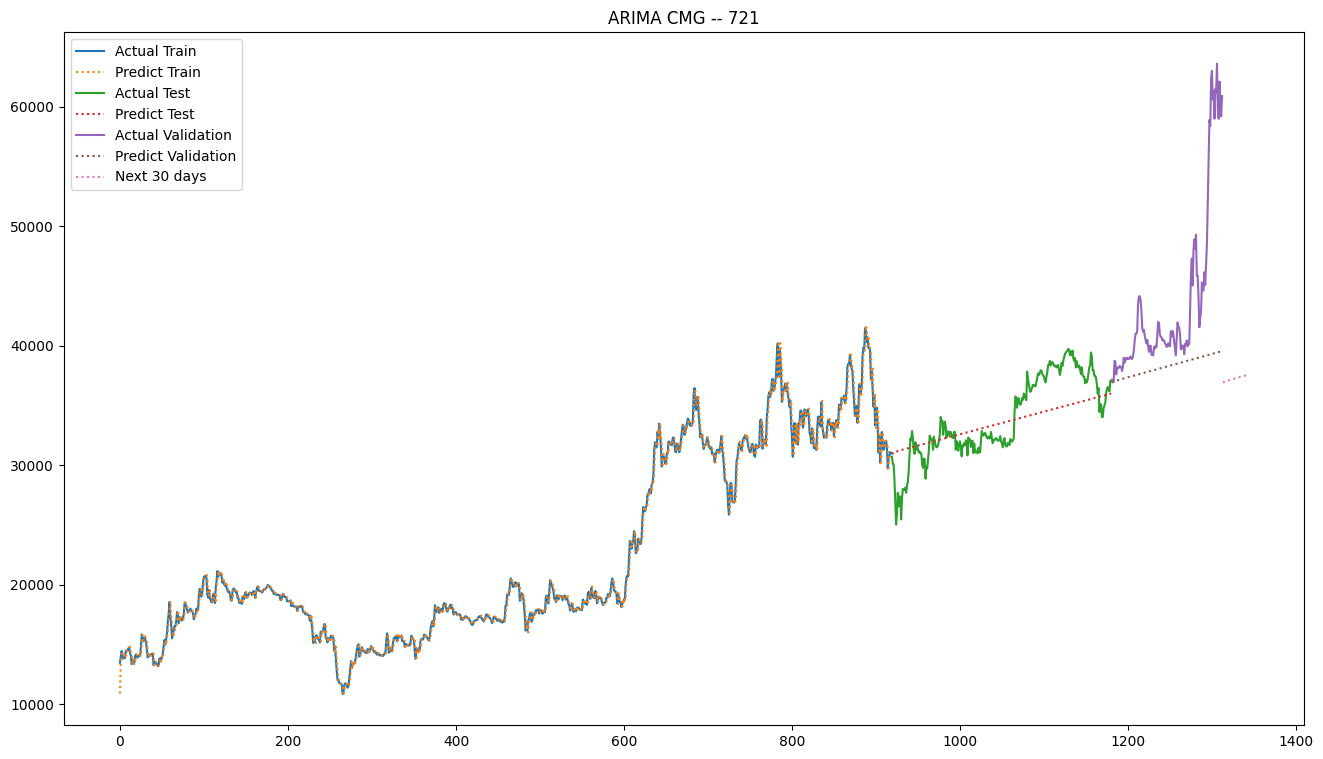

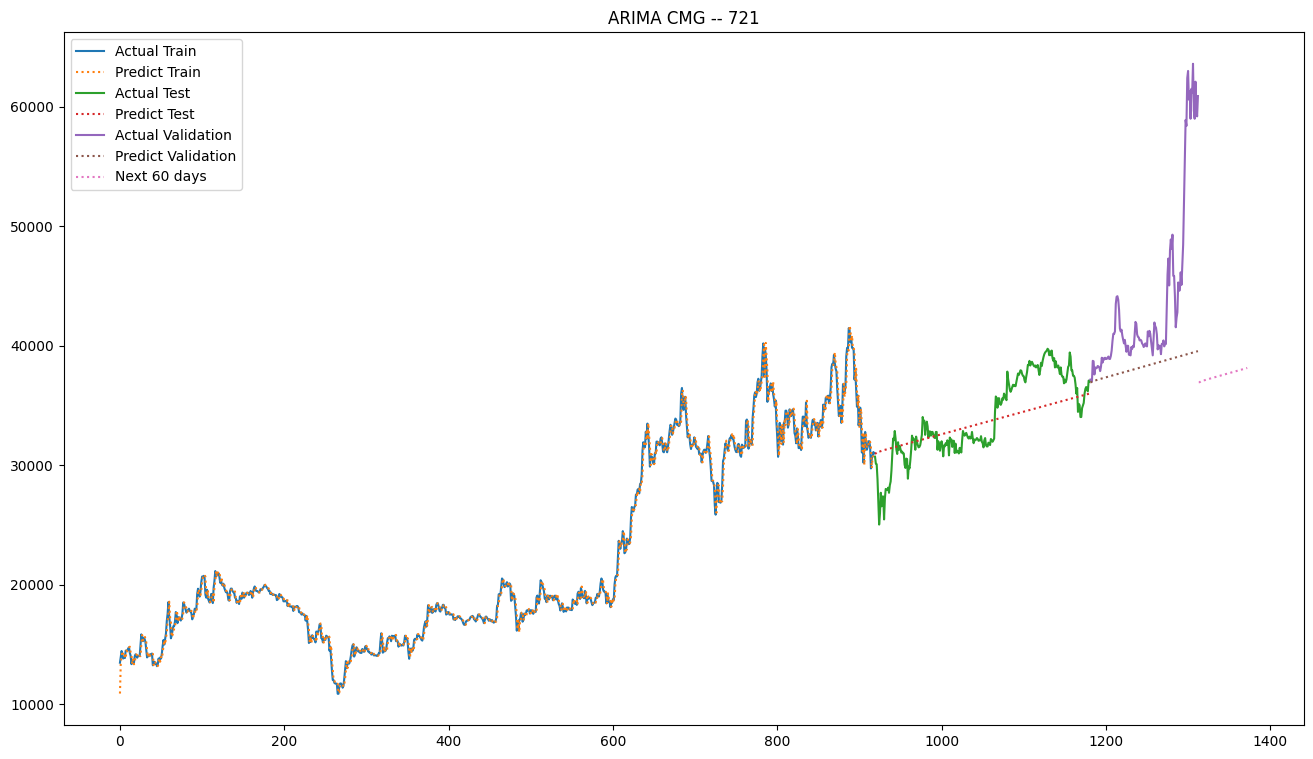

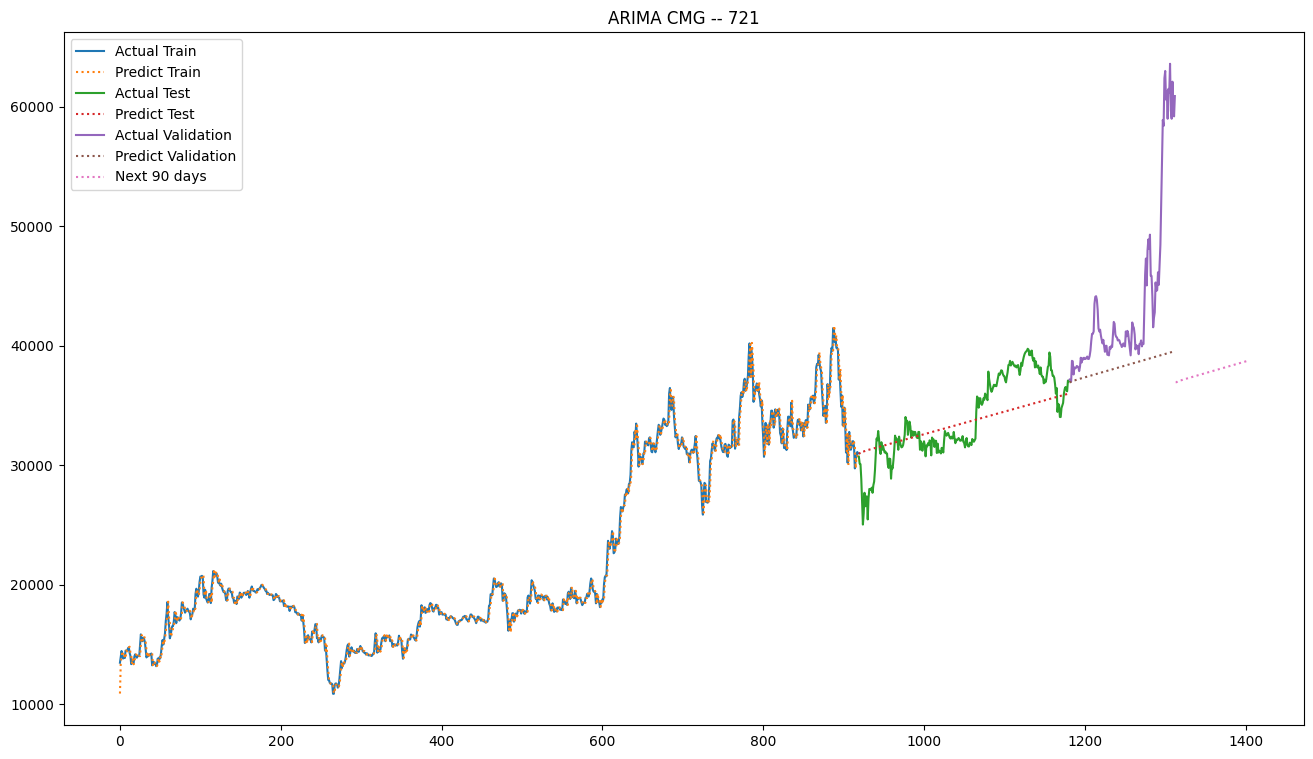

In [25]:
draw_plot(pred_future_30, 30)
draw_plot(pred_future_60, 60)
draw_plot(pred_future_90, 90)